In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "single_mag"
        self.nseqs = 8
        self.scaler = MinMaxScaler((-1,1))
        # self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 25
        self.G_niters = 10
        self.D_niters = 15
        
        self.model_out = Path('./runs/mad_single/' + time_id + '_nseq8')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    nseqs=opts.nseqs
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 8, 80)
Inputs head:
 [[[-0.4834911  -0.48303799 -0.48258295 ... -0.4732507  -0.47323848
   -0.47322587]
  [-0.47321287 -0.47319946 -0.47318563 ... -0.46989952 -0.46979875
   -0.46969518]
  [-0.46958874 -0.46947932 -0.46936684 ... -0.49868472 -0.5047416
   -0.51009456]
  ...
  [ 0.14182985  0.13306966  0.12450441 ... -0.26066855 -0.2443619
   -0.22767758]
  [-0.21061061 -0.19315627 -0.1753102  ...  0.84564376  0.85363252
    0.86135403]
  [ 0.86880804  0.87599466  0.88291439 ...  0.99983155  0.99984836
    0.99986353]]

 [[-0.47284225 -0.4723928  -0.47194147 ... -0.46362779 -0.46363526
   -0.46364247]
  [-0.46364942 -0.4636561  -0.4636625  ... -0.46255601 -0.46249912
   -0.46244008]
  [-0.46237881 -0.46231525 -0.4622493  ... -0.49886906 -0.50508199
   -0.51058958]
  ...
  [ 0.19823724  0.19087695  0.18360866 ... -0.15814856 -0.14058093
   -0.12264766]
  [-0.10434603 -0.08567364 -0.06662855 ...  0.87563428  0.88212928
    0.88839982]
  [ 0

Unscaled inputs shape: (11066, 640)


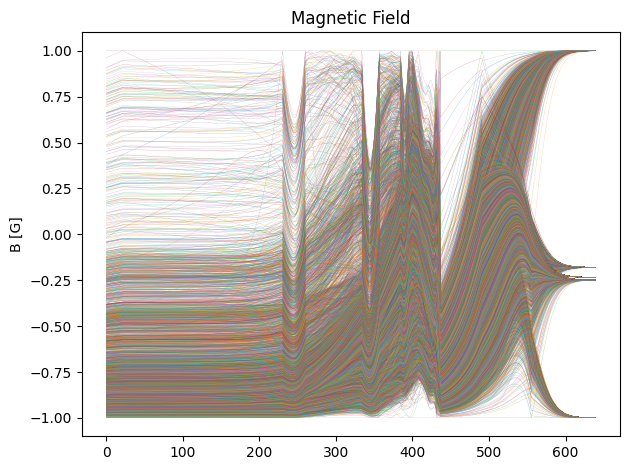

In [3]:
dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[2],
    hidden_size=150,
    output_size=dataset.inputs.shape[2],
    nlayers=4,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[2],
    hidden_size=150,
    nlayers=2,
    dropout=0.1,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


In [5]:
netG.train()

Generator(
  (rnn): GRU(80, 150, num_layers=4, batch_first=True)
  (linear): Linear(in_features=150, out_features=80, bias=True)
)

In [6]:
netD.train()

Discriminator(
  (rnn): GRU(80, 150, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=150, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
logger = SummaryWriter(f"logs/mad_gan_pca/{time_id}_D{netD.hidden_size}-L{netD.nlayers}_G{netG.hidden_size}-L{netG.nlayers}")
logger.add_graph(netG, torch.randn(opts.batch_size, opts.nseqs, dataset.inputs.shape[2]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size,opts.nseqs, dataset.inputs.shape[2]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

2023-03-14 18:14:24.179514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.nseqs

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 1 and D_x > 0.7: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[0/25]	Loss_D: 1.1249	Loss_G: 0.6890	D(x): 0.8781	D(G(z)): 0.5441


Epoch [1/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[1/25]	Loss_D: 1.9486	Loss_G: 0.3234	D(x): 0.6929	D(G(z)): 0.7413


Epoch [2/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[2/25]	Loss_D: 1.5901	Loss_G: 0.4047	D(x): 0.7056	D(G(z)): 0.6790


Epoch [3/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[3/25]	Loss_D: 1.4556	Loss_G: 0.5037	D(x): 0.6478	D(G(z)): 0.6143


Epoch [4/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[4/25]	Loss_D: 1.5900	Loss_G: 0.4410	D(x): 0.6340	D(G(z)): 0.6529


Epoch [5/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[5/25]	Loss_D: 1.7056	Loss_G: 0.4471	D(x): 0.6059	D(G(z)): 0.6513


Epoch [6/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[6/25]	Loss_D: 1.4940	Loss_G: 0.4661	D(x): 0.6599	D(G(z)): 0.6374


Epoch [7/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[7/25]	Loss_D: 1.5898	Loss_G: 0.4085	D(x): 0.6738	D(G(z)): 0.6737


Epoch [8/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[8/25]	Loss_D: 1.3593	Loss_G: 0.4998	D(x): 0.7153	D(G(z)): 0.6191


Epoch [9/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.6385	Loss_G: 0.4276	D(x): 0.6084	D(G(z)): 0.6606


Epoch [10/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[10/25]	Loss_D: 1.7023	Loss_G: 0.3737	D(x): 0.7676	D(G(z)): 0.7070


Epoch [11/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.3922	Loss_G: 0.7169	D(x): 0.5359	D(G(z)): 0.5025


Epoch [12/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[12/25]	Loss_D: 1.4508	Loss_G: 0.5968	D(x): 0.5984	D(G(z)): 0.5649


Epoch [13/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.3683	Loss_G: 0.7123	D(x): 0.5568	D(G(z)): 0.5091


Epoch [14/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[14/25]	Loss_D: 1.5026	Loss_G: 0.5711	D(x): 0.5644	D(G(z)): 0.5746


Epoch [15/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[15/25]	Loss_D: 2.0726	Loss_G: 0.3411	D(x): 0.6534	D(G(z)): 0.7305


Epoch [16/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[16/25]	Loss_D: 1.3249	Loss_G: 0.7441	D(x): 0.7113	D(G(z)): 0.5533


Epoch [17/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[17/25]	Loss_D: 1.3157	Loss_G: 0.9559	D(x): 0.6183	D(G(z)): 0.4750


Epoch [18/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[18/25]	Loss_D: 1.4028	Loss_G: 0.8705	D(x): 0.6274	D(G(z)): 0.5432


Epoch [19/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[19/25]	Loss_D: 1.1222	Loss_G: 1.2688	D(x): 0.6570	D(G(z)): 0.4254


Epoch [20/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[20/25]	Loss_D: 0.9930	Loss_G: 1.7715	D(x): 0.7717	D(G(z)): 0.4205


Epoch [21/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[21/25]	Loss_D: 0.5063	Loss_G: 2.1744	D(x): 0.8816	D(G(z)): 0.2580


Epoch [22/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[22/25]	Loss_D: 0.5820	Loss_G: 4.0357	D(x): 0.8355	D(G(z)): 0.1808


Epoch [23/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[23/25]	Loss_D: 1.3813	Loss_G: 0.6663	D(x): 0.7745	D(G(z)): 0.6140


Epoch [24/25]:   0%|          | 0/87 [00:00<?, ?it/s]

[24/25]	Loss_D: 1.8613	Loss_G: 0.2940	D(x): 0.7735	D(G(z)): 0.7582


In [10]:
logger.flush()

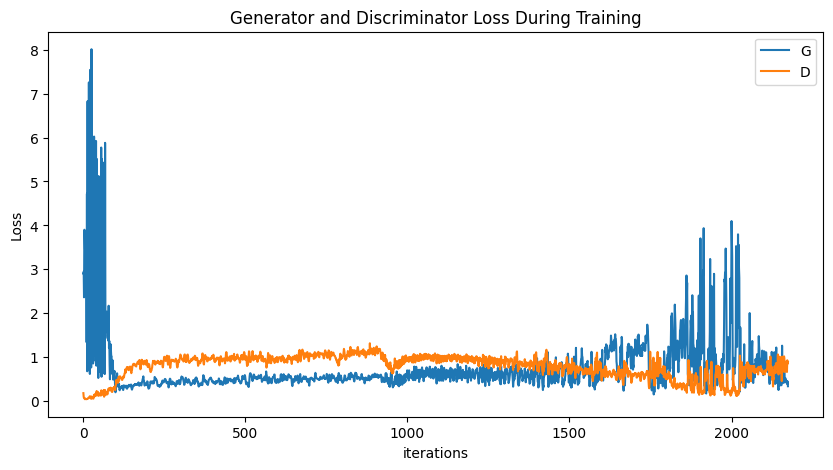

In [11]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [12]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [13]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [14]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [15]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/multi/0313-1135_w20_madgan_pca320")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'G10.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D10.pth'))

<All keys matched successfully>

In [16]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 8, 80)
Inputs head:
 [[[-0.4834911  -0.48303799 -0.48258295 ... -0.4732507  -0.47323848
   -0.47322587]
  [-0.47321287 -0.47319946 -0.47318563 ... -0.46989952 -0.46979875
   -0.46969518]
  [-0.46958874 -0.46947932 -0.46936684 ... -0.49868472 -0.5047416
   -0.51009456]
  ...
  [ 0.14182985  0.13306966  0.12450441 ... -0.26066855 -0.2443619
   -0.22767758]
  [-0.21061061 -0.19315627 -0.1753102  ...  0.84564376  0.85363252
    0.86135403]
  [ 0.86880804  0.87599466  0.88291439 ...  0.99983155  0.99984836
    0.99986353]]

 [[-0.47284225 -0.4723928  -0.47194147 ... -0.46362779 -0.46363526
   -0.46364247]
  [-0.46364942 -0.4636561  -0.4636625  ... -0.46255601 -0.46249912
   -0.46244008]
  [-0.46237881 -0.46231525 -0.4622493  ... -0.49886906 -0.50508199
   -0.51058958]
  ...
  [ 0.19823724  0.19087695  0.18360866 ... -0.15814856 -0.14058093
   -0.12264766]
  [-0.10434603 -0.08567364 -0.06662855 ...  0.87563428  0.88212928
    0.88839982]
  [ 0.89444659  0.90027053  0.90

## Discriminator Classification

In [29]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0].sum()
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.5034460425376892
Found 1177 anomalies


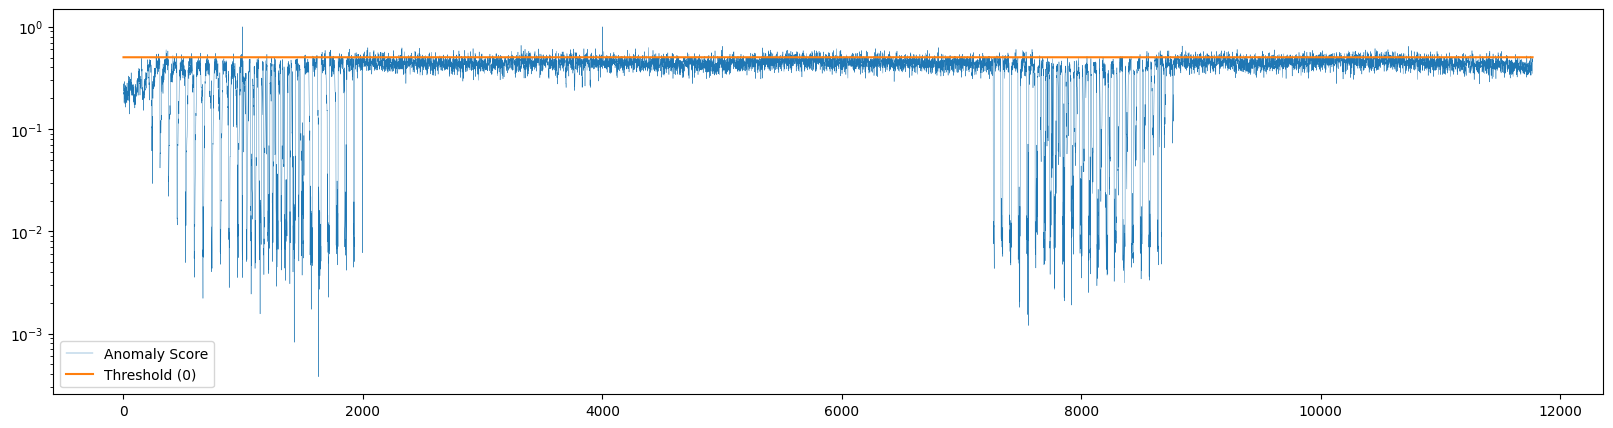

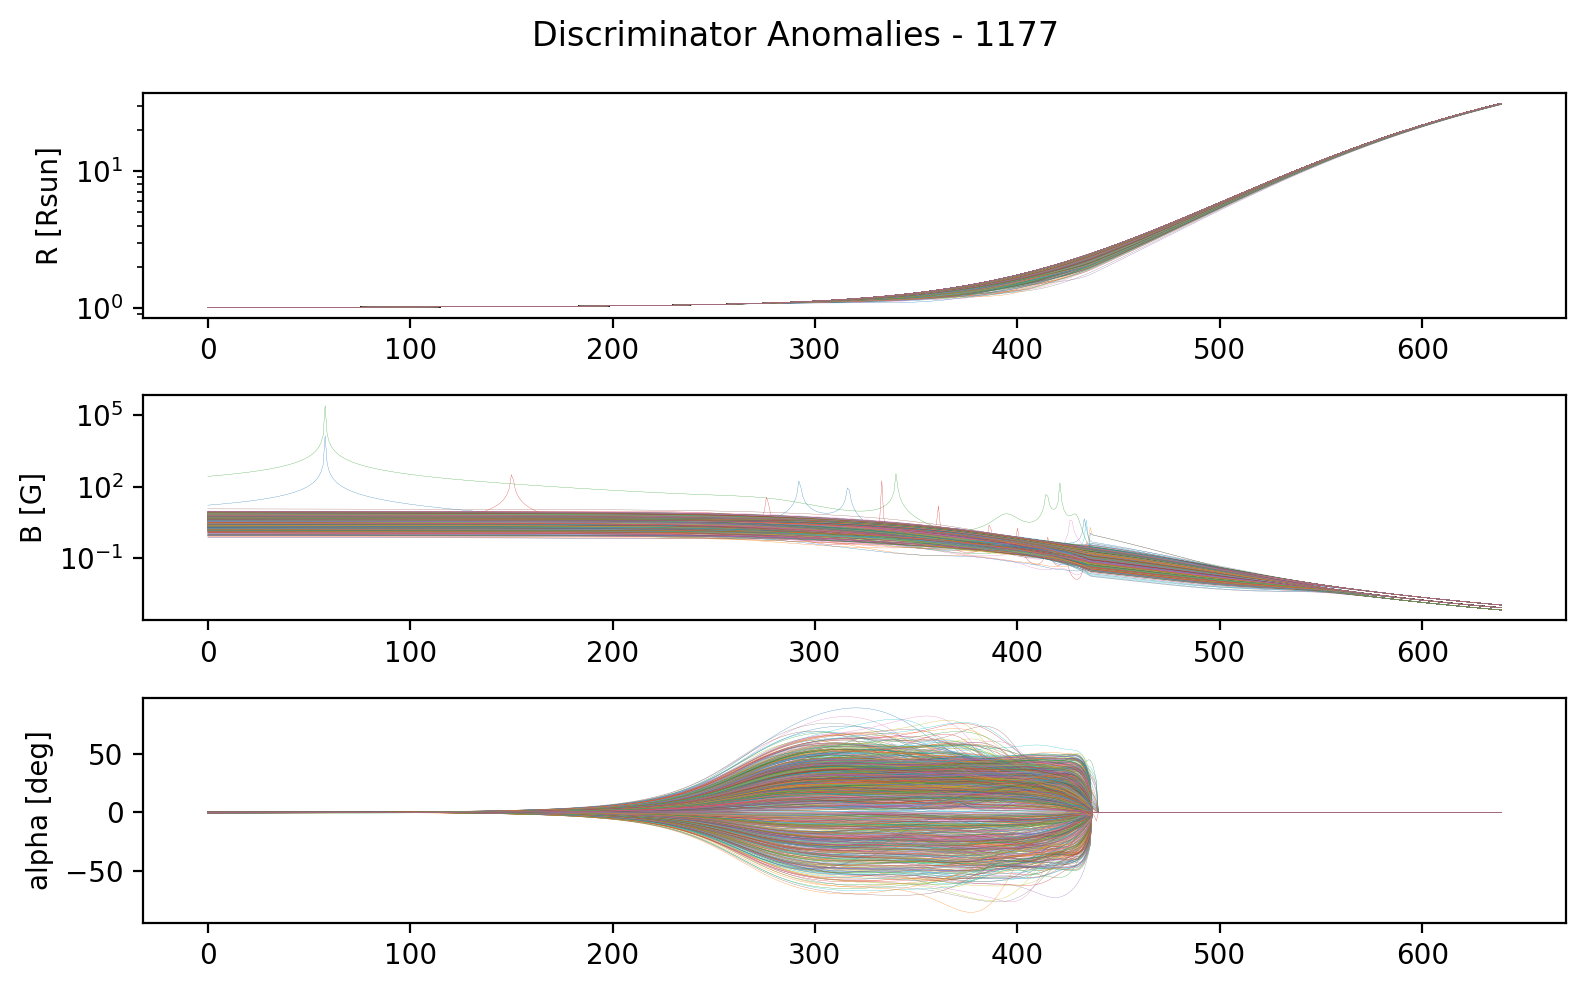

In [30]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="log", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [38]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        # print(loss.sum((1,2)).shape)
        # print(loss.sum((1,2)))
        loss = loss.sum((1,2))
        mse_scores.extend(zip(filenames, loss.detach().cpu().tolist()))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [39]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  46.73027038574219
Found 1177 anomalies


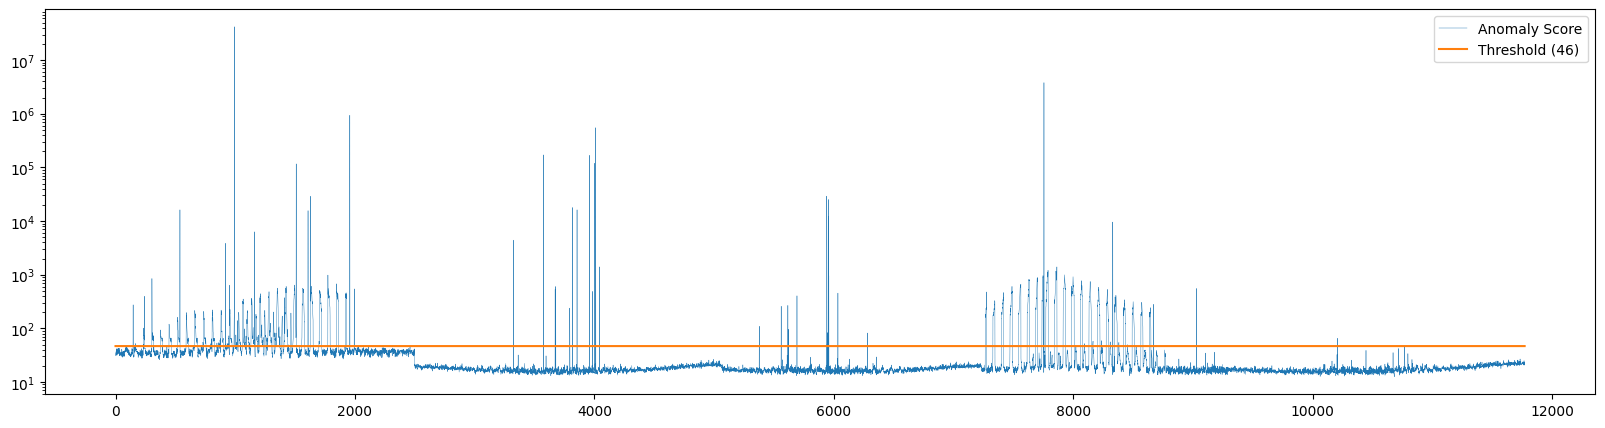

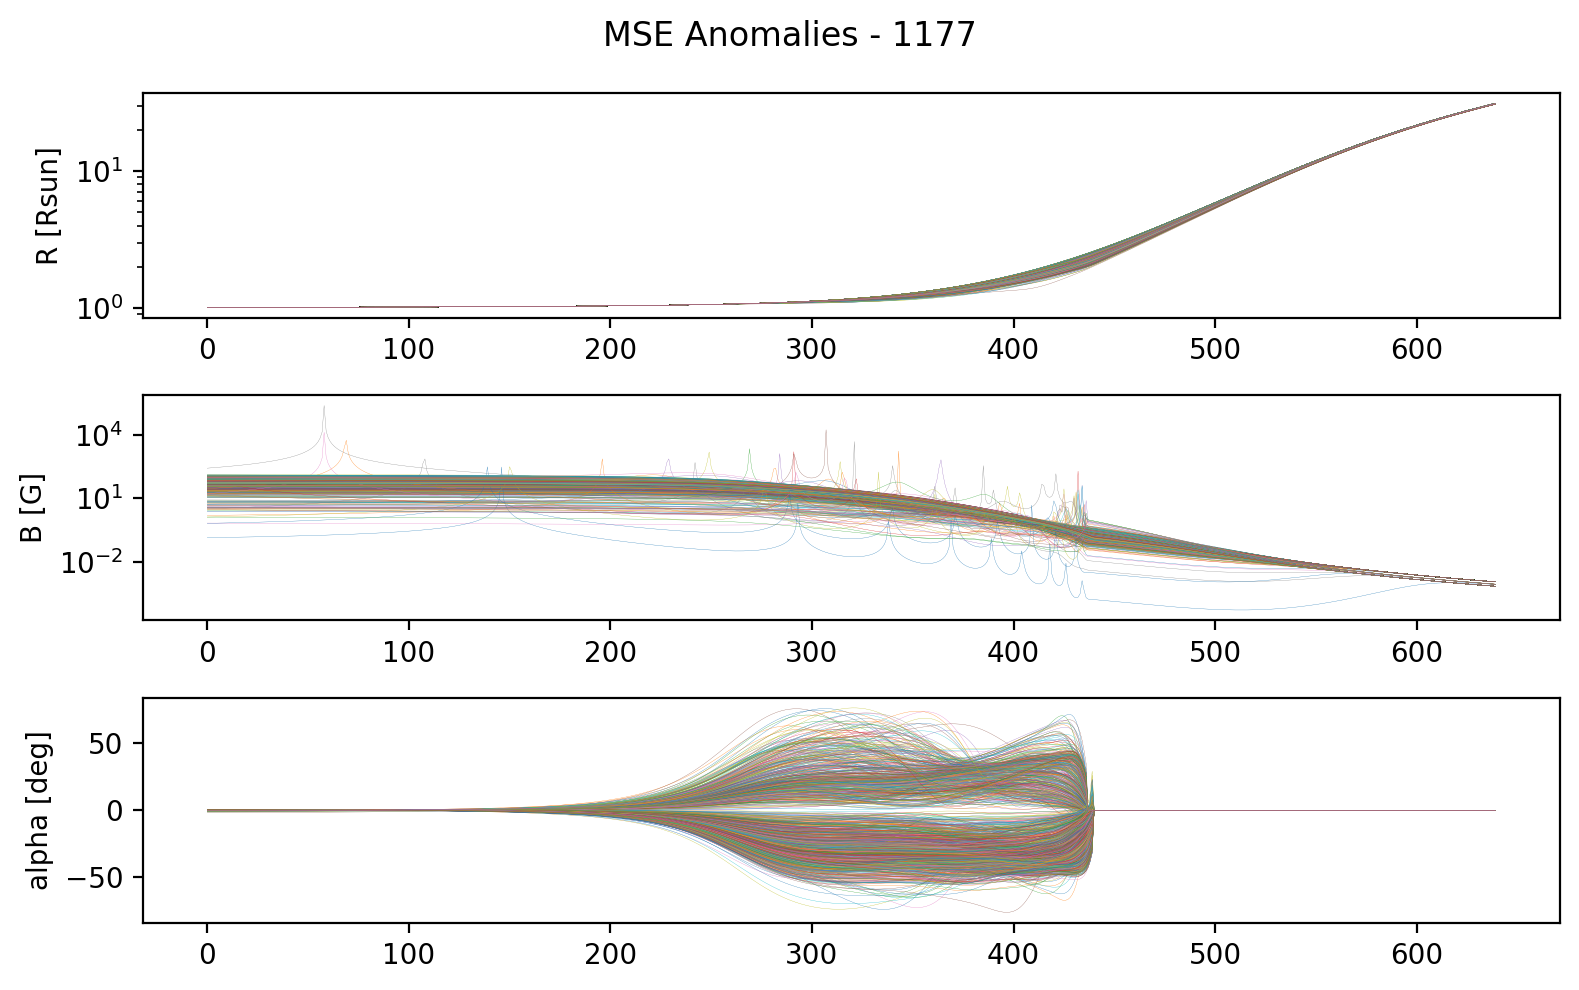

In [40]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", logger=logger, logger_var="test/mse")

### MSE Reconstruction with Discriminator feedback

In [41]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  11.95272445678711
Found 1177 anomalies


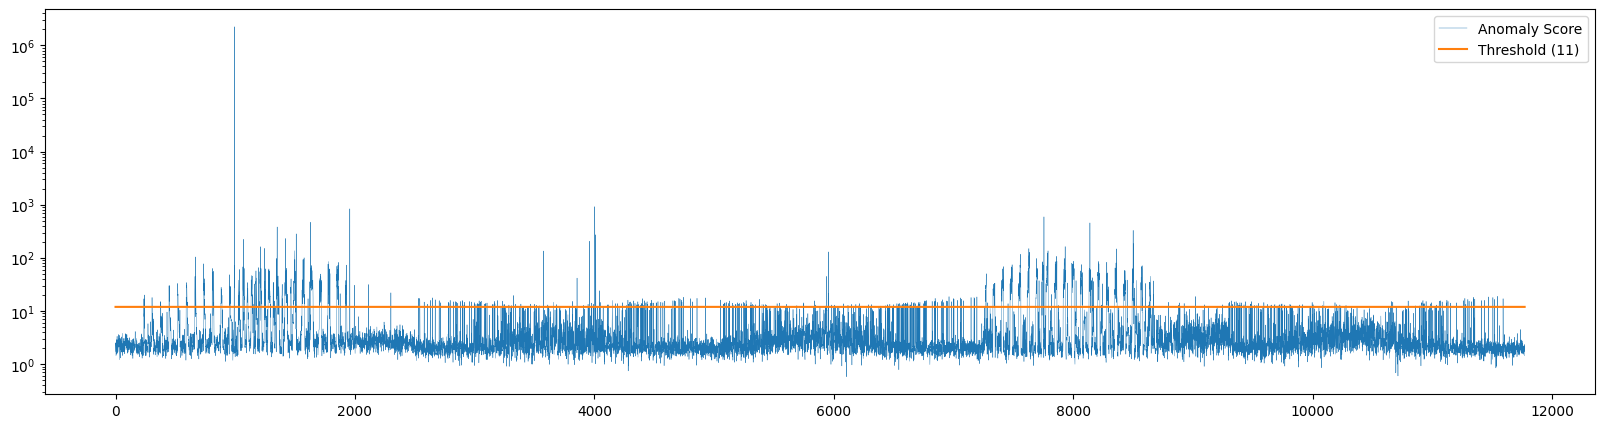

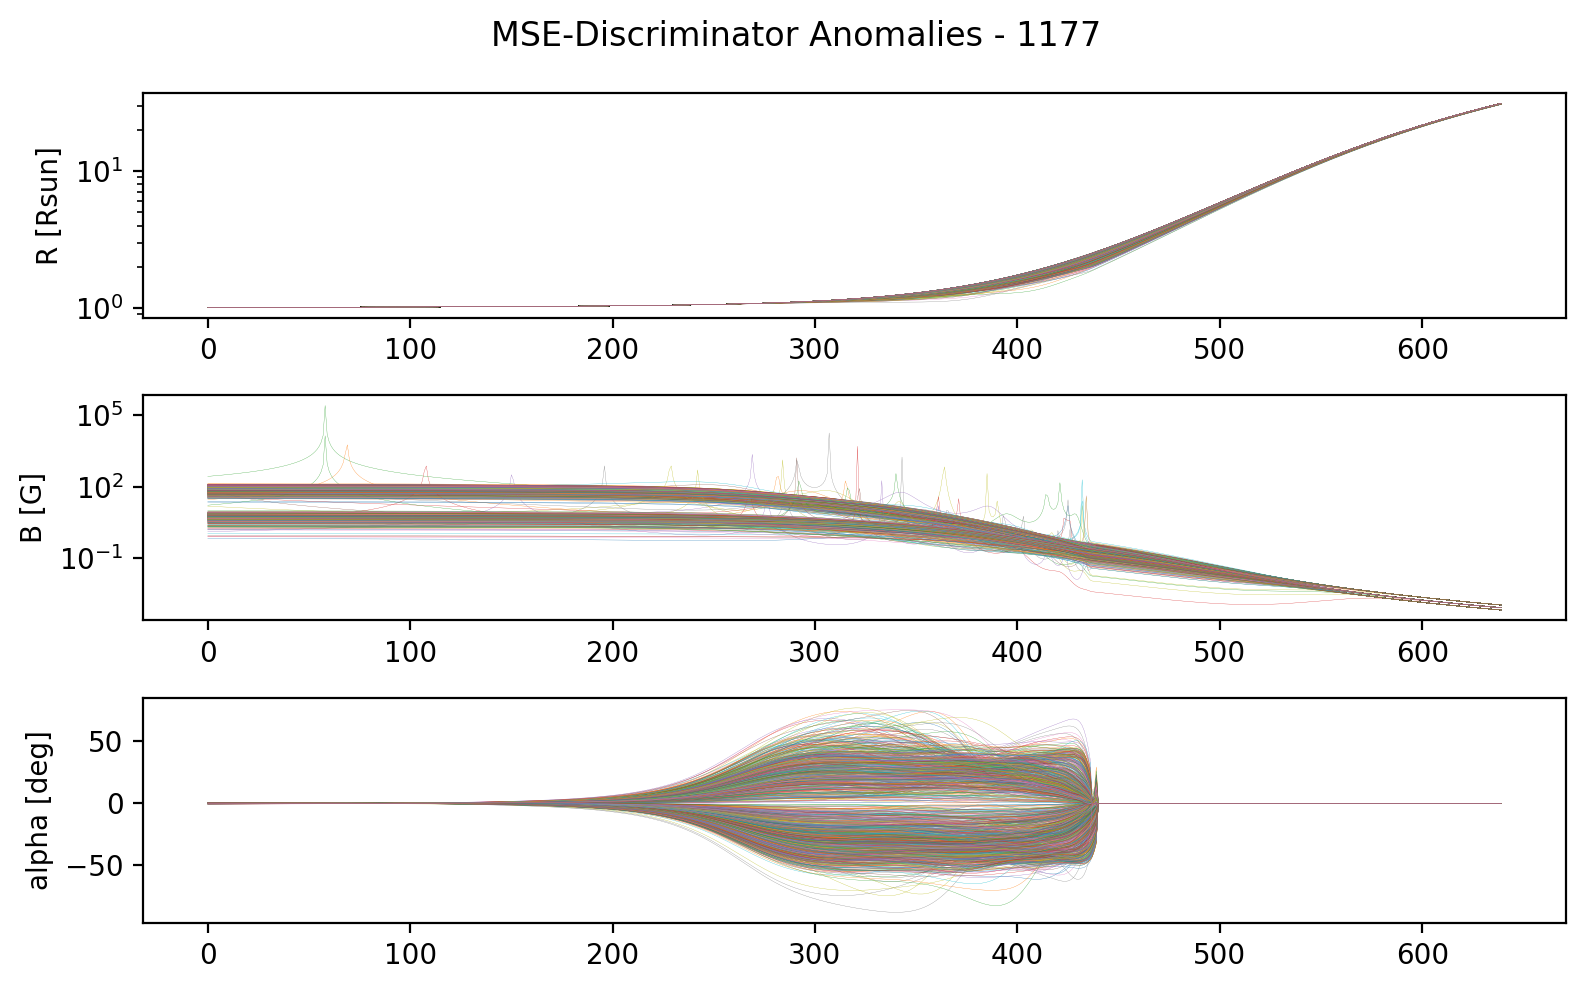

In [42]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [43]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  11.886184692382812
Found 1177 anomalies


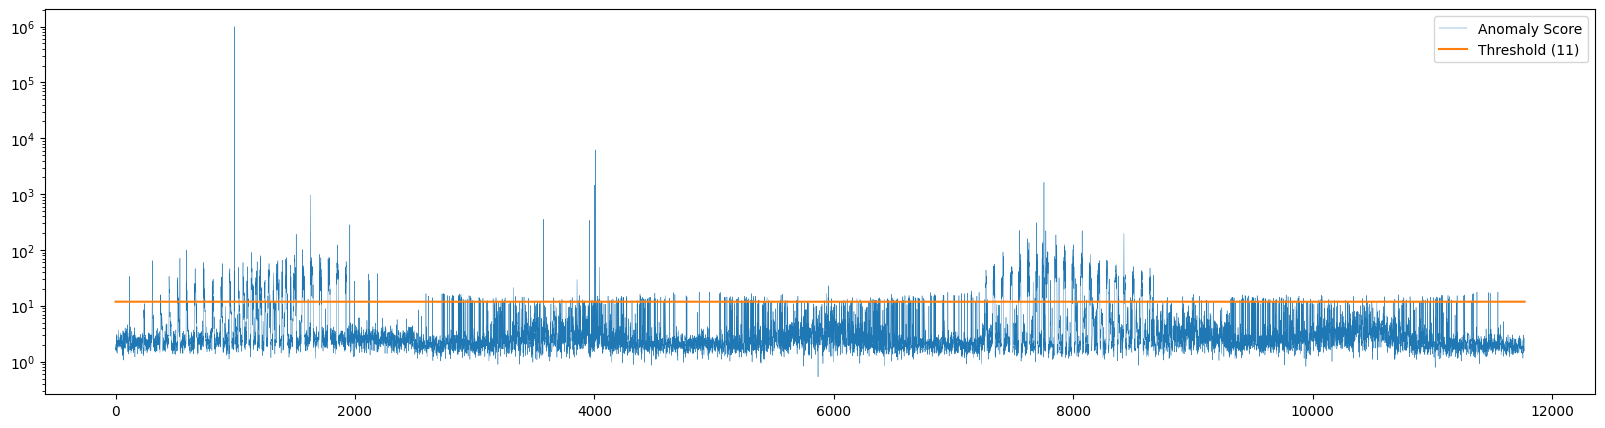

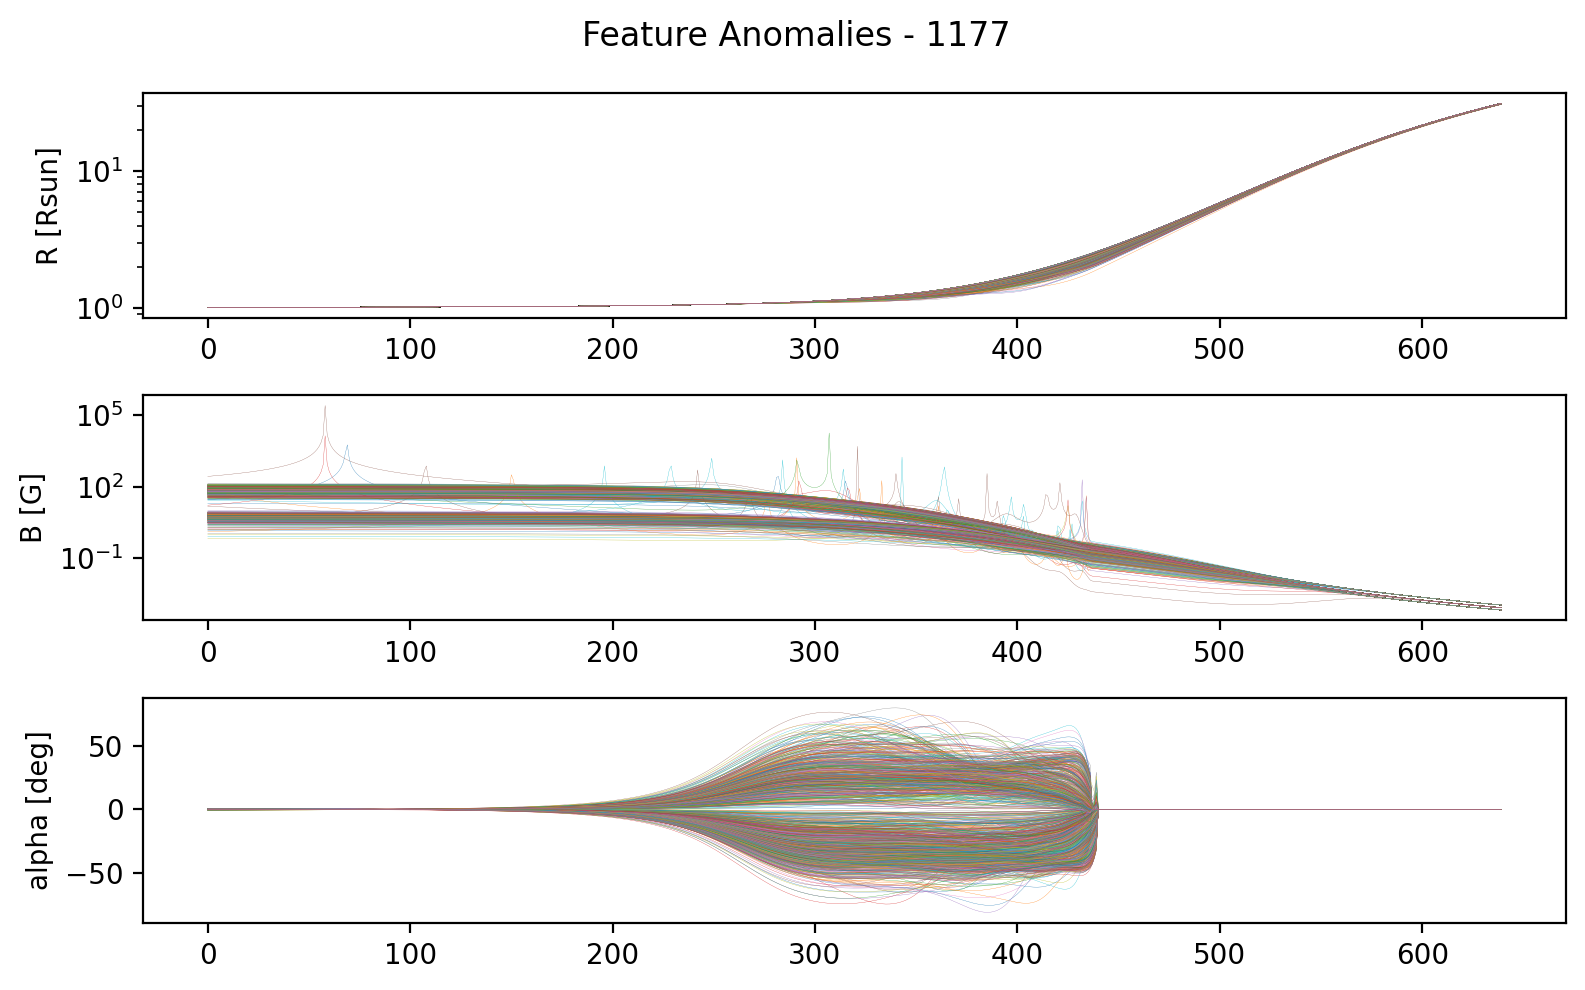

In [44]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

In [45]:
logger.flush()